In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [3]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Shape: (333, 500, 3)


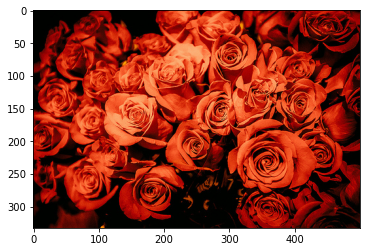

In [5]:
import cv2
roses = list(data_dir.glob('roses/*'))
plt.imshow(cv2.cvtColor(cv2.imread(str(roses[2])),cv2.COLOR_BGR2RGB))
print('Shape:',cv2.imread(str(roses[2])).shape)

Shape: (313, 500, 3)


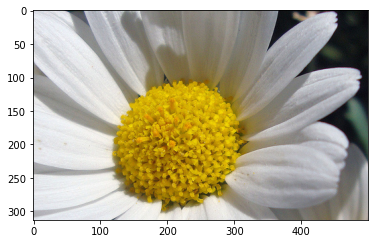

In [6]:
daisy = list(data_dir.glob('daisy/*'))
plt.imshow(cv2.cvtColor(cv2.imread(str(daisy[1])),cv2.COLOR_BGR2RGB))
print('Shape:',cv2.imread(str(daisy[1])).shape)

In [7]:
# read images into numpy
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [8]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

Shape: (237, 320, 3)


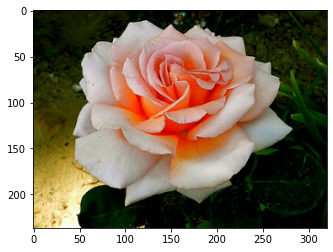

In [9]:
import random
num=random.randint(0,len(flowers_images_dict['roses'])-1)
plt.imshow(cv2.cvtColor(cv2.imread(str(flowers_images_dict['roses'][num])),cv2.COLOR_BGR2RGB))
print('Shape:',cv2.imread(str(flowers_images_dict['roses'][num])).shape)

In [10]:
# preprocessing
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [11]:
X = np.array(X)
y = np.array(y)

print('Shape of X:',X.shape)
print('Shape of y:',y.shape)

Shape of X: (3670, 180, 180, 3)
Shape of y: (3670,)


In [12]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [13]:
# normalize
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [14]:
num_classes = 5

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
86/86 [==============================] - 89s 1s/step - loss: 1.6157 - accuracy: 0.3225
Epoch 2/30
86/86 [==============================] - 82s 948ms/step - loss: 1.0726 - accuracy: 0.5787
Epoch 3/30
86/86 [==============================] - 83s 970ms/step - loss: 0.9390 - accuracy: 0.6246
Epoch 4/30
86/86 [==============================] - 85s 985ms/step - loss: 0.7419 - accuracy: 0.7195
Epoch 5/30
86/86 [==============================] - 81s 943ms/step - loss: 0.5728 - accuracy: 0.7920
Epoch 6/30
86/86 [==============================] - 82s 959ms/step - loss: 0.3677 - accuracy: 0.8698
Epoch 7/30
86/86 [==============================] - 83s 965ms/step - loss: 0.2260 - accuracy: 0.9273
Epoch 8/30
86/86 [==============================] - 83s 962ms/step - loss: 0.1285 - accuracy: 0.9700
Epoch 9/30
86/86 [==============================] - 82s 957ms/step - loss: 0.0700 - accuracy: 0.9808
Epoch 10/30
86/86 [==============================] - 84s 975ms/step - loss: 0.0399 - accuracy:

In [15]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 12s 360ms/step - loss: 2.4017 - accuracy: 0.6623


[2.4016566276550293, 0.6623093485832214]

train accuracy is very high (99%), the test accuracy is significantly low (66.23%) indicating overfitting

In [21]:
predictions = model.predict(X_test_scaled)

Original Label: daisy
Predicted Label: roses


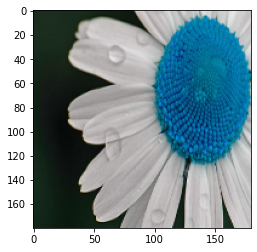

In [33]:
import random
num=random.randint(0,len(y_test)-1)
plt.imshow(X_test_scaled[num])
print('Original Label:',list(flowers_labels_dict.keys())[y_test[num]])
print('Predicted Label:',list(flowers_labels_dict.keys())[np.argmax(predictions[num])])

## Improve Test Accuracy Using Data Augmentation

In [34]:
img_height=180
img_width=180

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

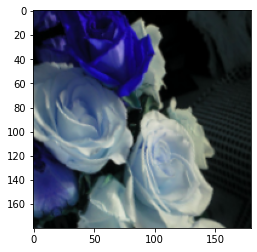

In [36]:
plt.imshow(data_augmentation(X)[1].numpy().astype("uint8"))

In [37]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30)  

Epoch 1/30
86/86 [==============================] - 99s 1s/step - loss: 1.6831 - accuracy: 0.2891
Epoch 2/30
86/86 [==============================] - 101s 1s/step - loss: 1.1250 - accuracy: 0.5390
Epoch 3/30
86/86 [==============================] - 101s 1s/step - loss: 0.9989 - accuracy: 0.6068
Epoch 4/30
86/86 [==============================] - 97s 1s/step - loss: 0.9488 - accuracy: 0.6264
Epoch 5/30
86/86 [==============================] - 98s 1s/step - loss: 0.8566 - accuracy: 0.6506
Epoch 6/30
86/86 [==============================] - 100s 1s/step - loss: 0.8317 - accuracy: 0.7001
Epoch 7/30
86/86 [==============================] - 98s 1s/step - loss: 0.7811 - accuracy: 0.7055
Epoch 8/30
86/86 [==============================] - 101s 1s/step - loss: 0.7124 - accuracy: 0.7355
Epoch 9/30
86/86 [==============================] - 99s 1s/step - loss: 0.6862 - accuracy: 0.7372
Epoch 10/30
86/86 [==============================] - 99s 1s/step - loss: 0.6672 - accuracy: 0.7462
Epoch 11/30
86/

In [38]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 9s 312ms/step - loss: 0.9844 - accuracy: 0.7288


[0.9844473004341125, 0.7287581562995911]

The accuracy of test set predictions is increased to 72.87% by data augmentation 

In [39]:
predictions = model.predict(X_test_scaled)

Original Label: daisy
Predicted Label: daisy


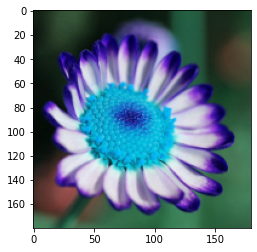

In [45]:
import random
num=random.randint(0,len(y_test)-1)
plt.imshow(X_test_scaled[num])
print('Original Label:',list(flowers_labels_dict.keys())[y_test[num]])
print('Predicted Label:',list(flowers_labels_dict.keys())[np.argmax(predictions[num])])